In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim


import optuna
from optuna.trial import TrialState

##BONUS: PYTORCH LIGHTNING
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping



from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score

seed=42 


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

In [2]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

In [3]:
df = pd.read_csv('sample_outMed.csv')
df = pd.get_dummies(df)

train_data = df[df['split_train'] == 1]
val_data = df[df['split_val'] == 1]
test_data = df[df['split_test']== 1]

X = df.drop(columns=['label', 'split_test', 'split_train', 'split_val', 'pe_type_central', 'pe_type_segmental', 'pe_type_subsegmental', 'pred', 'Unnamed: 0', 'idx'], axis=1)
Y = df['label']

In [4]:
X_train = train_data.drop(columns=['label', 'split_test', 'split_train', 'split_val', 'pe_type_central', 'pe_type_segmental', 'pe_type_subsegmental', 'pred', 'Unnamed: 0', 'idx'], axis=1)
X_val = val_data.drop(columns=['label', 'split_test', 'split_train', 'split_val', 'pe_type_central', 'pe_type_segmental', 'pe_type_subsegmental', 'pred', 'Unnamed: 0', 'idx'], axis=1)
X_test = test_data.drop(columns=['label', 'split_test', 'split_train', 'split_val', 'pe_type_central', 'pe_type_segmental', 'pe_type_subsegmental', 'pred', 'Unnamed: 0', 'idx'], axis=1)

y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

In [5]:
X_train.shape

(1454, 566)

In [6]:
scaler = StandardScaler()   
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)          
X_test = scaler.transform(X_test)

In [7]:
pca = PCA()
pca.fit_transform(X_train);

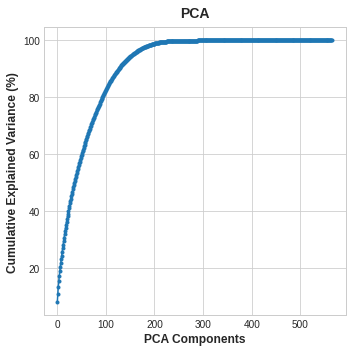

In [8]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]

plt.figure(figsize=(5,5))
plt.plot(comp, cum_sum, marker='.')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [10]:
class CustomDataset:
    def __init__(self, X_data, y_data, device=DEVICE):
        self.X_data = X_data
        self.y_data = y_data 
    
    def __len__ (self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [11]:
train_data = CustomDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))

In [12]:
val_data = CustomDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val.values))

In [13]:
test_data = CustomDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.values))

In [14]:
BATCHSIZE = 8

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCHSIZE)
valid_loader = DataLoader(dataset=val_data, batch_size=2)
test_loader = DataLoader(dataset=test_data, batch_size=2)

In [16]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_features = 566
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_{}".format(i), 8, 25)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))
        in_features=out_features
    layers.append(nn.Linear(out_features, 1))

    return nn.Sequential(*layers)

In [17]:
EPOCHS = 40

In [18]:
def objective(trial):
    
    # call the define_model method
    model = define_model(trial).to(DEVICE)

    # Optimizer and loss definition
    lr = trial.suggest_float("lr", 5e-4, 1e-2, log=True)
    optimizer =  getattr(optim, 'Adam')(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss() 
    # Using the logit binary CE, we include the sigmoid function in the prediction output during the loss calculation
    
    train_acc = []
    train_loss = []
    
    valid_acc = []
    valid_loss = []
    
    total_step = len(train_loader)
    total_step_val = len(valid_loader)

    for epoch in range(EPOCHS):
        
        running_loss=0
        correct=0
        total=0
        
        #TRAINING

        model.train()

        for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
            X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)
            optimizer.zero_grad()
            output = model(X_train_batch)
            y_pred = torch.round(torch.sigmoid(output))
            #LOSS
            loss = criterion(output, y_train_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss+=loss.item() #sum all batch losses
            #ACCURACY
            correct += torch.sum(y_pred==y_train_batch.unsqueeze(1)).item()
            total += y_train_batch.size(0)
        train_acc.append(100 * correct / total) 
        train_loss.append(running_loss/total_step) #get average loss among all batches dividing total loss by the number of batches

        # VALIDATION
        correct_v = 0
        total_v = 0
        batch_loss = 0
        with torch.no_grad():
            model.eval()
            for batch_idx, (X_valid_batch, y_valid_batch) in enumerate(valid_loader):
                X_valid_batch,y_valid_batch=X_valid_batch.to(DEVICE),y_valid_batch.to(DEVICE)
                #PREDICTION
                output = model(X_valid_batch)
                y_pred = torch.round(torch.sigmoid(output))
                #LOSS
                loss_v = criterion(output, y_valid_batch.unsqueeze(1))
                batch_loss+=loss_v.item()
                #ACCURACY
                correct_v += torch.sum(y_pred==y_valid_batch.unsqueeze(1)).item()
                total_v += y_valid_batch.size(0)
            valid_acc.append(100 * correct_v / total_v)
            valid_loss.append(batch_loss/total_step_val)

        trial.report(np.mean(valid_loss), epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return np.mean(valid_acc)

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")

params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2022-04-16 16:07:25,360] A new study created in memory with name: no-name-16e2b5a6-6ffd-4ab6-bad2-67e55518f0ae
[I 2022-04-16 16:07:54,474] Trial 0 finished with value: 44.01554404145078 and parameters: {'n_layers': 1, 'n_units_0': 11, 'dropout_0': 0.40068195197230927, 'lr': 0.00101079808665992}. Best is trial 0 with value: 44.01554404145078.
[I 2022-04-16 16:08:22,573] Trial 1 finished with value: 44.22279792746114 and parameters: {'n_layers': 1, 'n_units_0': 17, 'dropout_0': 0.4187060264786149, 'lr': 0.002717749093192317}. Best is trial 1 with value: 44.22279792746114.
[I 2022-04-16 16:08:54,369] Trial 2 finished with value: 45.16839378238342 and parameters: {'n_layers': 2, 'n_units_0': 8, 'dropout_0': 0.2615661636286679, 'n_units_1': 8, 'dropout_1': 0.25769742940173246, 'lr': 0.009221394178951528}. Best is trial 2 with value: 45.16839378238342.
[I 2022-04-16 16:09:25,989] Trial 3 finished with value: 44.10621761658032 and parameters: {'n_layers': 2, 'n_units_0': 16, 'dropout_0': 0

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  73
  Number of complete trials:  27
Best trial:
  Value:  45.16839378238342
  Params: 
    n_layers: 2
    n_units_0: 8
    dropout_0: 0.2615661636286679
    n_units_1: 8
    dropout_1: 0.25769742940173246
    lr: 0.009221394178951528


In [20]:
params

[2, 8, 0.2615661636286679, 8, 0.25769742940173246, 0.009221394178951528]

In [21]:
n_layers = params[0]

units_1 = params[1]
dropout_1 = np.round(params[2],5)

lr = np.round(params[3],8)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(X_train.shape[1], units_1)
        self.layer_out = nn.Linear(units_1, 1) 
        self.dropout1 = nn.Dropout(p=dropout_1)
        
    def forward(self, inputs):
        x = F.relu(self.layer_1(inputs))
        x = self.dropout1(x)
        x = self.layer_out(x)
        
        return x

In [23]:
model = Net()
model.to(DEVICE)
print(model)

Net(
  (layer_1): Linear(in_features=566, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (dropout1): Dropout(p=0.26157, inplace=False)
)


In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

In [25]:
EPOCHS = 100

In [26]:
# Model Training

early_stopping_patience = 15
early_stopping_counter = 0

train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

total_step = len(train_loader)
total_step_val = len(valid_loader)

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    
    running_loss=0
    correct=0
    total=0
    
    #TRAINING

    model.train()

    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(DEVICE), y_train_batch.to(DEVICE)
        optimizer.zero_grad()
        output = model(X_train_batch)
        y_pred = torch.round(torch.sigmoid(output))
        #LOSS
        loss = criterion(output, y_train_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss+=loss.item() #sum loss for every batch
        #ACCURACY
        correct += torch.sum(y_pred==y_train_batch.unsqueeze(1)).item()
        total += y_train_batch.size(0)
    train_acc.append(100 * correct / total) #calculate accuracy among all entries in the batches
    train_loss.append(running_loss/total_step)  #get average loss among all batches dividing total loss by the number of batches

    # VALIDATION
    correct_v = 0
    total_v = 0
    batch_loss = 0
    with torch.no_grad():
        model.eval()
        for batch_idx, (X_valid_batch, y_valid_batch) in enumerate(valid_loader):
            X_valid_batch,y_valid_batch=X_valid_batch.to(DEVICE),y_valid_batch.to(DEVICE)
            #PREDICTION
            output = model(X_valid_batch)
            y_pred = torch.round(torch.sigmoid(output))
            #LOSS
            loss_v = criterion(output, y_valid_batch.unsqueeze(1))
            batch_loss+=loss_v.item()
            #ACCURACY
            correct_v += torch.sum(y_pred==y_valid_batch.unsqueeze(1)).item()
            total_v += y_valid_batch.size(0)
        valid_acc.append(100 * correct_v / total_v) 
        valid_loss.append(batch_loss/total_step_val)
    
    
    if np.mean(valid_loss) <= valid_loss_min:
        torch.save(model.state_dict(), '/home/bmlserver/jk/iPynb/mmF_Final/savedModel/outMed_state_dict.pt')
        print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {np.mean(valid_loss):.6f}).  Saving model ...')
        valid_loss_min = np.mean(valid_loss)
        early_stopping_counter=0 #reset counter if validation loss decreases
    else:
        print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
        early_stopping_counter+=1

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', epoch)
        break

    print(f'\t Train_Loss: {np.mean(train_loss):.4f} Train_Acc: {(100 * correct / total):.3f} Val_Loss: {np.mean(valid_loss):.4f}  BEST VAL Loss: {valid_loss_min:.4f}  Val_Acc: {(100 * correct_v / total_v):.3f}\n')

Epoch 0: Validation loss decreased (inf --> 156721.672863).  Saving model ...
	 Train_Loss: 125596.6049 Train_Acc: 54.333 Val_Loss: 156721.6729  BEST VAL Loss: 156721.6729  Val_Acc: 39.378

Epoch 1: Validation loss decreased (156721.672863 --> 103963.336346).  Saving model ...
	 Train_Loss: 101606.0892 Train_Acc: 56.809 Val_Loss: 103963.3363  BEST VAL Loss: 103963.3363  Val_Acc: 37.824

Epoch 2: Validation loss decreased (103963.336346 --> 94196.020175).  Saving model ...
	 Train_Loss: 81355.0529 Train_Acc: 56.465 Val_Loss: 94196.0202  BEST VAL Loss: 94196.0202  Val_Acc: 43.523

Epoch 3: Validation loss decreased (94196.020175 --> 93778.584615).  Saving model ...
	 Train_Loss: 74659.6546 Train_Acc: 56.121 Val_Loss: 93778.5846  BEST VAL Loss: 93778.5846  Val_Acc: 42.487

Epoch 4: Validation loss decreased (93778.584615 --> 86560.578870).  Saving model ...
	 Train_Loss: 64710.0351 Train_Acc: 57.634 Val_Loss: 86560.5789  BEST VAL Loss: 86560.5789  Val_Acc: 40.933

Epoch 5: Validation loss

In [27]:
y_pred_prob_list = []
y_pred_list = []


# Loading the best model
model.load_state_dict(torch.load('/home/bmlserver/jk/iPynb/mmF_Final/savedModel/outMed_state_dict.pt'))

with torch.no_grad():
        model.eval()
        for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
            X_test_batch = X_test_batch.to(DEVICE)
            #PREDICTION
            output = model(X_test_batch)
            y_pred_prob = torch.sigmoid(output)
            y_pred_prob_list.append(y_pred_prob.cpu().numpy())
            y_pred = torch.round(y_pred_prob)
            y_pred_list.append(y_pred.cpu().numpy())

In [28]:
outMed_pred = [a.tolist() for a in y_pred_prob_list]

outMed_pred_np = np.array(outMed_pred)

outMed_predTT = outMed_pred_np.reshape((190, 1))

np.savetxt('outMed_pred.csv',outMed_predTT,delimiter=",")

In [30]:
# outMed_predTT

# %store outMed_predTT

Stored 'outMed_predTT' (ndarray)


In [29]:
# y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
# y_pred_list = [a.squeeze().tolist() for a in y_pred_list]